In [2]:
!pip install kaggle==1.5.12


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=64620284df763904e47869e78316bd3b695e7f8945536e24ebdea1efdefcac39
  Stored in directory: /root/.cache/pip/wheels/2e/27/39/f44e52756a6407b444143f233abe9fda0e18a23e8b20e0cd1c
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d manmandes/malimg

100% 1.09G/1.09G [00:20<00:00, 63.3MB/s]
100% 1.09G/1.09G [00:20<00:00, 57.4MB/s]


In [6]:
import zipfile

zip_file_path = 'malimg.zip'
extraction_path = 'malimg_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [7]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf


In [8]:
path_root = "/content/malimg_data/malimg_dataset"

In [9]:
path_root = "/content/malimg_data/malimg_dataset"
train_path = os.path.join(path_root, "/content/malimg_data/malimg_dataset/train")
test_path = os.path.join(path_root, "/content/malimg_data/malimg_dataset/test")
val_path = os.path.join(path_root, "/content/malimg_data/malimg_dataset/val")

In [10]:
def create_dataframe(data_path):
    images = []
    labels = []
    for class_folder in os.listdir(data_path):
        class_path = os.path.join(data_path, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            images.append(image_path)
            labels.append(class_folder)
    df = pd.DataFrame({'img_code': images, 'target': labels})
    return df


train_df = create_dataframe(train_path)
val_df = create_dataframe(val_path)


train_df = pd.concat([train_df, val_df], ignore_index=True)


test_df = create_dataframe(test_path)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 8382 validated image filenames belonging to 25 classes.
Found 957 validated image filenames belonging to 25 classes.


In [12]:
classes = train_gen.class_indices

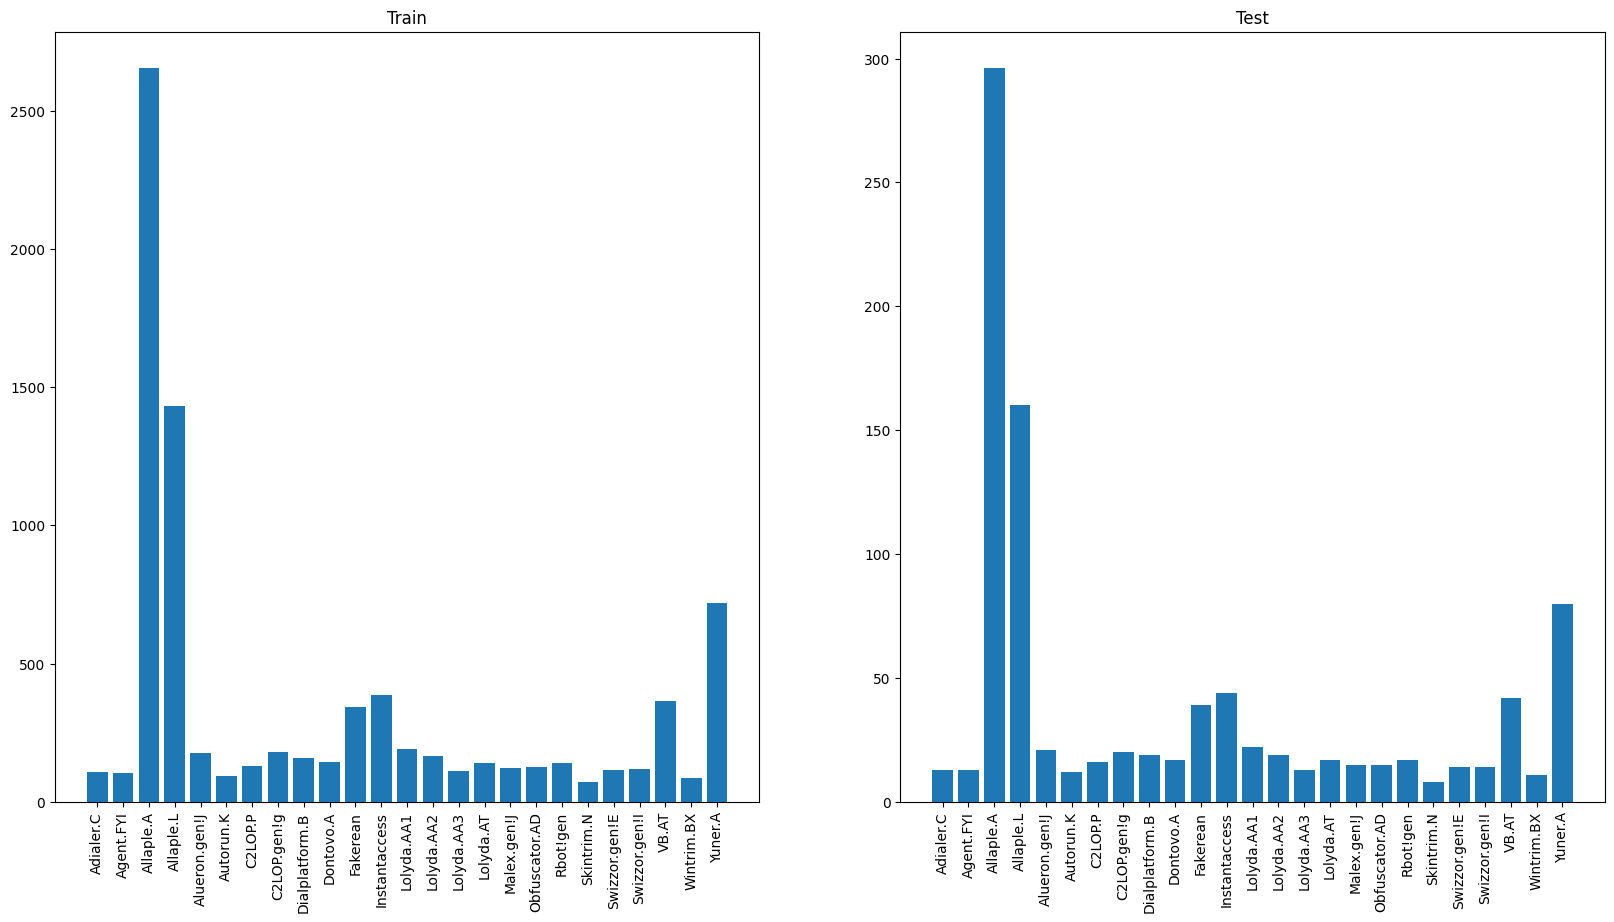

In [13]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ]
name = ["Train", "Test"]

plt.figure(figsize = (20,10))

for i in range(2):

  plt.subplot(1,2,i+1)
  plt.title(name[i])
  plt.xticks(rotation = "vertical")
  plt.bar(classes.keys(), occur[i])

plt.show()

In [14]:
class_index = {'Adialer.C': 0,
                'Agent.FYI': 1,
                'Allaple.A': 2,
                'Allaple.L': 3,
                'Alueron.gen!J': 4,
                'Autorun.K': 5,
                'C2LOP.P': 6,
                'C2LOP.gen!g': 7,
                'Dialplatform.B': 8,
                'Dontovo.A': 9,
                'Fakerean': 10,
                'Instantaccess': 11,
                'Lolyda.AA1': 12,
                'Lolyda.AA2': 13,
                'Lolyda.AA3': 14,
                'Lolyda.AT': 15,
                'Malex.gen!J': 16,
                'Obfuscator.AD': 17,
                'Rbot!gen': 18,
                'Skintrim.N': 19,
                'Swizzor.gen!E': 20,
                'Swizzor.gen!I': 21,
                'VB.AT': 22,
                'Wintrim.BX': 23,
                'Yuner.A': 24}

In [15]:
train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

<ipython-input-15-442ddd885c22>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_df.replace({"target":class_index})['target'].to_numpy()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{np.int64(0): np.float64(3.0759633027522937),
 np.int64(1): np.float64(3.255145631067961),
 np.int64(2): np.float64(0.12637768563889937),
 np.int64(3): np.float64(0.23429769392033542),
 np.int64(4): np.float64(1.8942372881355931),
 np.int64(5): np.float64(3.566808510638298),
 np.int64(6): np.float64(2.579076923076923),
 np.int64(7): np.float64(1.8626666666666667),
 np.int64(8): np.float64(2.122025316455696),
 np.int64(9): np.float64(2.3122758620689656),
 np.int64(10): np.float64(0.9803508771929824),
 np.int64(11): np.float64(0.8663565891472869),
 np.int64(12): np.float64(1.7553926701570681),
 np.int64(13): np.float64(2.032),
 np.int64(14): np.float64(3.048),
 np.int64(15): np.float64(2.3611267605633803),
 np.int64(16): np.float64(2.770909090909091),
 np.int64(17): np.float64(2.64),
 np.int64(18): np.float64(2.3778723404255317),
 np.int64(19): np.float64(4.656666666666666),
 np.int64(20): np.float64(2.9410526315789474),
 np.int64(21): np.float64(2.8413559322033897),
 np.int64(22): np.fl

<BarContainer object of 25 artists>

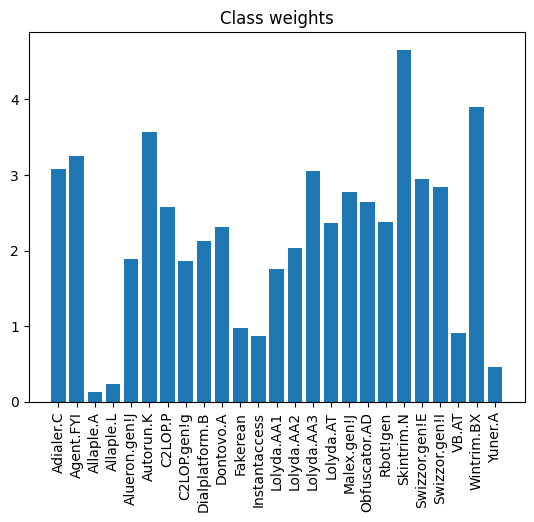

In [17]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [19]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model

In [20]:
Malware_model = malware_model()
Malware_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,389 (1.69 MB)

 Trainable params: 443,389 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history=Malware_model.fit(train_gen,epochs=10,validation_data=test_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.3389 - loss: 2.3449 - weighted_accuracy: 0.3389 - val_accuracy: 0.8924 - val_loss: 0.4571 - val_weighted_accuracy: 0.8924
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.7974 - loss: 0.7254 - weighted_accuracy: 0.7974 - val_accuracy: 0.9007 - val_loss: 0.3743 - val_weighted_accuracy: 0.9007
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.8653 - loss: 0.4500 - weighted_accuracy: 0.8653 - val_accuracy: 0.9478 - val_loss: 0.1727 - val_weighted_accuracy: 0.9478
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.8958 - loss: 0.3213 - weighted_accuracy: 0.8958 - val_accuracy: 0.9561 - val_loss: 0.1477 - val_weighted_accuracy: 0.9561
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.9089 - loss: 0.2989 - weighted_accuracy: 0.9089 - val_accuracy: 0.9624 - val_loss: 0.1163 - val_weighted_accuracy: 0.9624
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 32s 1

In [23]:
Malware_model.save("my_malware_model.h5")

In [24]:
from google.colab import files
files.download("my_malware_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>